# Training a ResBet-50-based classifier to classify images as bottles or cans

In [ ]:
!pip3 install Pillow==9.2.0
!pip3 install 'whylogs[whylabs]'
!pip3 install pandas
!pip3 install tensorflow
!pip3 install pydot
!pip3 install tf2onnx
!pip3 install tensorrt --extra-index-url https://pypi.nvidia.com

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model

import whylogs
from whylogs.extras.image_metric import log_image
from whylogs.api.writer.whylabs import WhyLabsWriter

from PIL import Image
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
# Set WhyLabs environment variables
# Make sure no spaces are in your string
os.environ['WHYLABS_API_KEY'] = 'YOUR_WHYLABS_API_KEY'
os.environ["WHYLABS_DEFAULT_ORG_ID"] = 'YOUR_WHYLABS_ORG_ID'
os.environ["WHYLABS_DEFAULT_DATASET_ID"] = 'YOUR_WHYLABS_DATASET_ID'

In [51]:
# Hyperparameters
# - image_size: the size of images to be trained on
# - batch_size: the number of images to process before updating the model's weights
# - epochs: the number of times to iterate over the entire dataset
# - lr: the learning rate of the optimizer
image_size = (180, 180)
batch_size = 10
epochs = 3
lr = 0.001

base_dir = '/home/shibley/development/bevnet/img/'

# Load & split the dataset into training & validation sets (80:20 split)
train_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir+'full',
  validation_split=0.2,
  subset="training",
  image_size=image_size,
  seed=31,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir+'full',
  validation_split=0.2,
  subset="validation",
  seed=31,
  image_size=image_size,
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir+'test',
  validation_split=None,
  labels=None,
  image_size=image_size,
  seed=31,
  batch_size=batch_size)

Found 703 files belonging to 2 classes.
Using 563 files for training.


Found 703 files belonging to 2 classes.
Using 140 files for validation.
Found 12 files belonging to 1 classes.


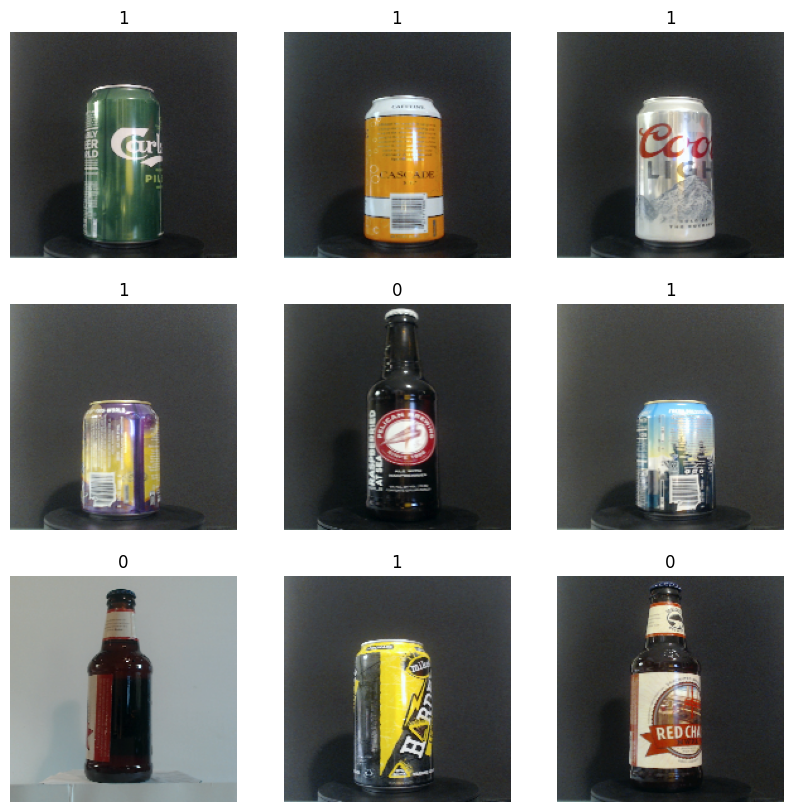

In [17]:
# Display a sampling of the dataset with labels
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### I use WhyLabs to profile the training set and characterize the distribution of data
WhyLabs is also useful later for monitoring model performance

In [ ]:
writer = WhyLabsWriter().option(reference_profile_name="training_ref_profile")

merged_profile = None

# Iterate over the dataset to profile the images
for images, labels in train_ds.take(1):
  for image in images:
    PIL_image = Image.fromarray(image.numpy().astype("uint8"))
    profile = log_image(PIL_image).profile()
    profile_view = profile.view() # extract mergeable profile view

    # Merge the profile view of each batch into an accumulated profile
    if merged_profile is None:
      merged_profile = profile_view
    else:
      merged_profile = merged_profile.merge(profile_view)

writer.write(file=merged_profile)

In [20]:
# Display the profile
prof_df = merged_profile.to_pandas()
prof_df

,image/Brightness.mean:cardinality/est,image/Brightness.mean:cardinality/lower_1,image/Brightness.mean:cardinality/upper_1,image/Brightness.mean:counts/inf,image/Brightness.mean:counts/n,image/Brightness.mean:counts/nan,image/Brightness.mean:counts/null,image/Brightness.mean:distribution/max,image/Brightness.mean:distribution/mean,image/Brightness.mean:distribution/median,...,image/entropy:distribution/q_95,image/entropy:distribution/q_99,image/entropy:distribution/stddev,image/entropy:types/boolean,image/entropy:types/fractional,image/entropy:types/integral,image/entropy:types/object,image/entropy:types/string,image/entropy:types/tensor,type
column,,,,,,,,,,,,,,,,,,,,,
image,10.0,10.0,10.0005,0,10,0,0,144.62642,76.45054,74.688611,...,8.128604,8.128604,0.245585,0,10,0,0,0,0,SummaryType.COLUMN


### I'll introduce additional variation by augmenting the data with mirroring and rotation of images

In [21]:
# Define data augmentations
# - RandomFlip: flips the image horizontally at random
# - RandomRotation: rotates the image randomly between -10% and 10% of the image height and width
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

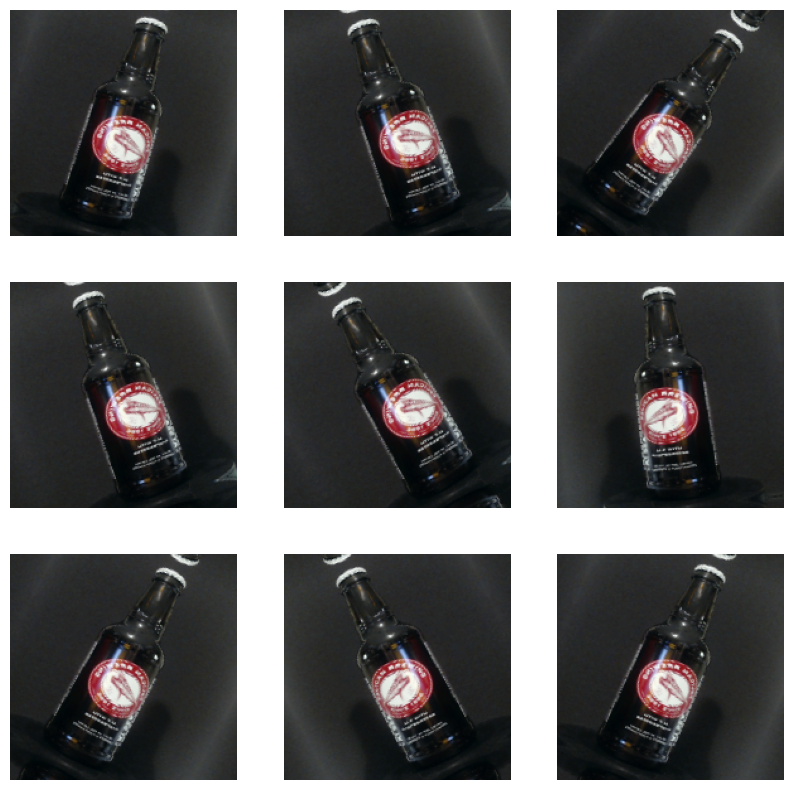

In [22]:
# Display a sampling of an augmented image in the dataset
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [23]:
# Apply augmentation to the training images
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Define the model
We'll use a pre-trained ResNet50 model and freeze all but the output layer, utilizing the model's already learned feature extraction.
We replace the output layer with a binary classification output layer and train it to classify images as having a can or a bottle using our training set.

In [28]:
# Using ResNet50 as the base with weights from ImageNet
# Since this is a binary classifier, it will use sigmoid activation for the output layer
def resnet50(input_shapes, num_classes, weights='imagenet'):

    pretrained_model = tf.keras.applications.ResNet50(
                    include_top=False,
                    input_shape=input_shapes,
                    pooling='avg',
                    classes=num_classes,
                    weights=weights)

    inputs = keras.Input(shape=input_shapes)

    # Freeze the the pretrained model's layers - we'll only be training the output layer
    for layer in pretrained_model.layers:
        layer.trainable=False

    # Define the output layer
    x = layers.Flatten()(pretrained_model.output)
    x = layers.Dense(512, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(pretrained_model.input, outputs)

In [29]:
r50_model = resnet50((180,180,3), num_classes=2)

94765736/94765736 [==============================] - 9s 0us/step


Optionally plot the model or view the model output at https://netron.app

In [ ]:
# Plot the model (requires graphviz)
keras.utils.plot_model(r50_model, show_shapes=True)

### Execute Training

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
r50_model.compile(
    optimizer=keras.optimizers.Adam(lr),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
r50_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/3
57/57 [==============================] - 17s 275ms/step - loss: 0.0724 - accuracy: 0.9680 - val_loss: 1.8784e-04 - val_accuracy: 1.0000
Epoch 2/3
57/57 [==============================] - 16s 280ms/step - loss: 4.5919e-04 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 3/3
57/57 [==============================] - 16s 281ms/step - loss: 5.5671e-05 - accuracy: 1.0000 - val_loss: 8.9158e-04 - val_accuracy: 1.0000


In [32]:
# Load in the trained model
r50_model2 = load_model('save_at_3.keras')

## Let's look at random samples from the validation set

1/1 [==============================] - 0s 193ms/step


/tmp/ipykernel_486758/1712228186.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[i])


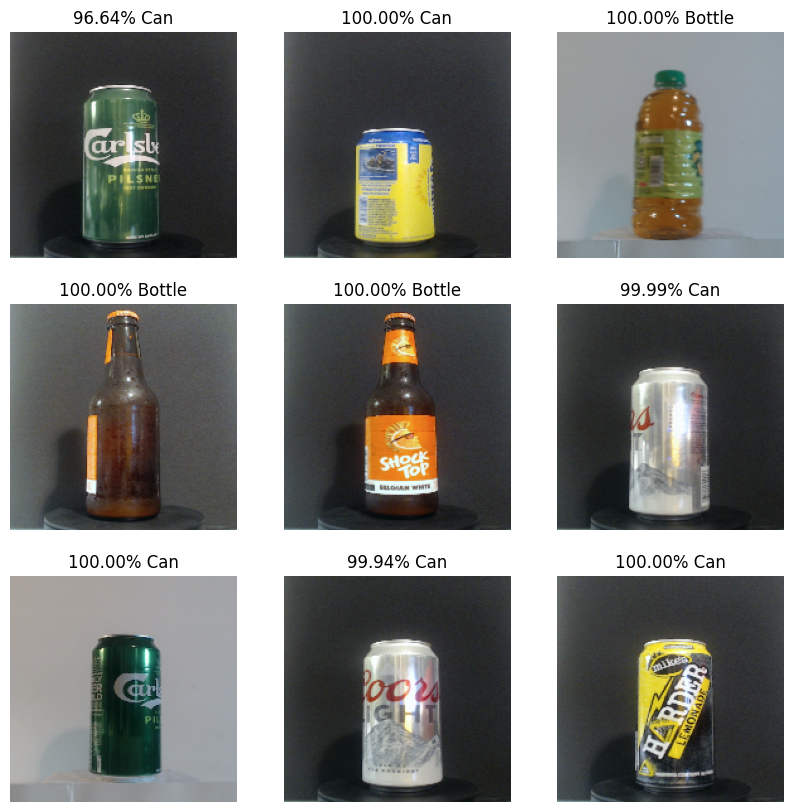

In [35]:
# Make predictions on the validation set, and display the results
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    predictions = r50_model2.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        score = float(predictions[i])
        if int(labels[i]) == 0:
            title = f"{100 * (1 - score):.2f}% Bottle"
        else:
            title = f"{100 * score:.2f}% Can"
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(title)
        plt.axis("off")

## And lets look at some samples from the test set
Note the the model did a reasonable job generalizing to properly classify with a busy (non-black/white) background and even to a bottle laying on its side.

1/1 [==============================] - 0s 208ms/step


/tmp/ipykernel_486758/693403796.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[i])


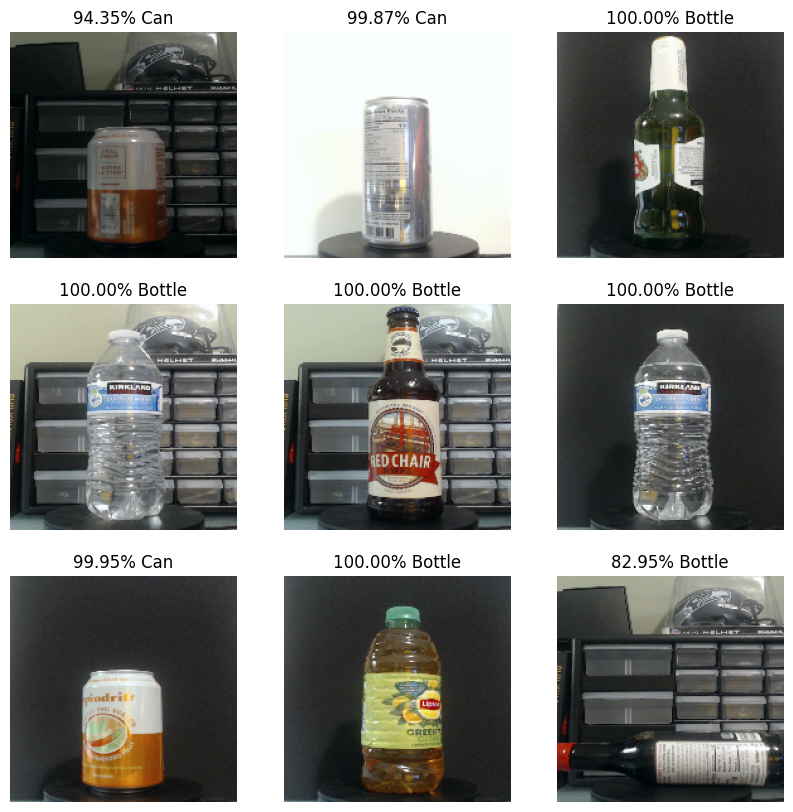

In [53]:
# Make predictions on the validation set, and display the results
plt.figure(figsize=(10, 10))
for images in test_ds.take(1):
    predictions = r50_model2.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        score = float(predictions[i])
        if score < 0.5:
            title = f"{100 * (1 - score):.2f}% Bottle"
        else:
            title = f"{100 * score:.2f}% Can"
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(title)
        plt.axis("off")

### Convert the model to onnx in preparation to convert to TensorRT for Nvidia Jetson

In [ ]:
r50_model2.save("saved_model1")
!python3 -m tf2onnx.convert --saved-model "saved_model1" --output "model1.onnx"

In [ ]:
# Can be converted on Jetson:
#!/usr/src/tensorrt/bin/trtexec --onnx=model1.onnx --explicitBatch --minShapes='input_1':1x180x180x3 --optShapes='input_1':2x180x180x3 --maxShapes='input_1':8x180x180x3 --workspace=4096 --buildOnly --saveEngine=resnet50_engine.trt --fp16